# Температура стали при ее обработке

### Введение

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Наша задача - построить модель, которая предскажет температуру стали.

**Т.о., нам предстоит решить задачу регрессии - определить численное значение целевого признака "температура".  
В качестве метрики будем использовать МАЕ (mean absolute error, среднее абсолютное отклонение), целевое значение - не более 6.8.** 

В отличие от MSE (mean squared error) МАЕ достаточно легко трактуется - будет просто объяснить клиенту физический смысл погрешности предсказания.

*Описание этапа обработки*

Сталь обрабатывают в ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры электродами.  
Добавлением примесей корректируется химический состав сплава и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный аппарат.  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. <span style="color:blue">*Целевой признак нашей задачи: последняя измеренная температура.* </span>   
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.  

*Описание данных*

Данные состоят из файлов, полученных из разных источников:  
•	data_arc.csv — данные об электродах;  
•	data_bulk.csv — данные о подаче сыпучих материалов (объём);  
•	data_bulk_time.csv — данные о подаче сыпучих материалов (время);  
•	data_gas.csv — данные о продувке сплава газом;  
•	data_temp.csv — результаты измерения температуры;  
•	data_wire.csv — данные о проволочных материалах (объём);  
•	data_wire_time.csv — данные о проволочных материалах (время).  
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки либо разным моментам измерения температуры.

### 1. Исследовательский анализ данных.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузка данных
data_arc = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_arc.csv')
data_bulk = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_bulk.csv')
data_bulk_time = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_bulk_time.csv')
data_wire = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_wire.csv')
data_wire_time = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_wire_time.csv')
data_gas = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_gas.csv')
data_temp = pd.read_csv('C:\\dm\\DM documents\\Data Science\\ВЫПУСКНОЙ ПРОЕКТ\\datasets\\data_temp.csv')

In [3]:
# общий вид датасетов, проверка на наличие пропусков, дупликатов, проверка типа данных
features = {'data_arc': data_arc, 'data_bulk': data_bulk, 'data_bulk_time': data_bulk_time, 'data_wire': data_wire, 'data_wire_time': data_wire_time, 'data_gas': data_gas, 'data_temp': data_temp}
for feature, file in features.items():
    print (feature, ' Первые пять строк базы данных')
    print ()
    print (file.head())
    print ()
    print (feature, ' Общая информация - проверка на наличие пропусков, проверка типа данных')
    print ()
    print (file.info())
    print ()
    print (feature, ' Количество дупликатов строк:',file.duplicated().sum())
    print ()

data_arc  Первые пять строк базы данных

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397  

data_arc  Общая информация - проверка на наличие пропусков, проверка типа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактив

**Замечания по общему виду датасетов**

Датасеты data_bulk, data_bulk_time, data_wire, data_wire_time, data_gas в несколько раз короче датасетов data_arc, data_temp. Если сравнить метки времени в этих наборах данных, то напрашивается вывод, что датасет data_temp представляет из себя запись в хронологическом порядке замеров температуры, не привязанных к итерациям обработки, т.е. к этапам добавления примесей. А датасеты data_bulk, data_bulk_time, data_wire, data_wire_time - запись данных о добавлении примесей в каждую партию. Поэтому на этапе предобработки оставим для каждой партии только первый и последний замер температуры.

Ниже преведено сравнение количества партий ('key' - номер партии) и числа замеров температуры в табличной и графической форме.

In [4]:
key_vs_temp_mark = pd.DataFrame(data = [len(data_arc['key'].unique()),len(data_bulk['key'].unique()), len(data_wire['key'].unique()), len(data_gas['key'].unique()), len(data_temp['key'].unique()), len(data_temp)], columns = ['qty'], index = ['arc_key_qty', 'bulk_key_qty', 'wire_key_qty', 'gas_key_qty', 'temp_key_qty', 'temp_mark_qty'])

In [5]:
key_vs_temp_mark

,qty
arc_key_qty,3214
bulk_key_qty,3129
wire_key_qty,3081
gas_key_qty,3239
temp_key_qty,3216
temp_mark_qty,15907


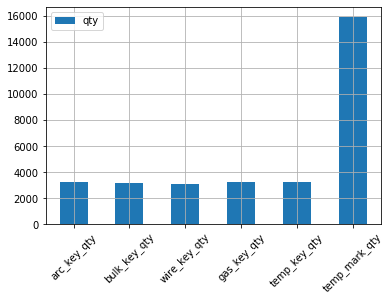

In [6]:
key_vs_temp_mark.plot.bar(grid=True, rot=45)

Как видим, партия проходит в среднем около пяти замеров температуры. Важно отметить, что по существенному количеству партий нет информации о добавлении примесей. Желательно запросить возможность предоставления этой информации (либо подтвердить, что примеси не добавлялись).

**Замечания по пропускам данных**

Пропуски в датасетах data_bulk, data_wire заменим на 0 - примеси не добавлялись.  
Пропуски в датасетах data_bulk_time, data_wire_time обрабатывать не будем.

Пропуски в столбце "Температура" датасета data_temp - это отсутствие значения целевого признака. Поэтому мы будем вынуждены удалить эти строки.

In [7]:
# процент наблюдений, запланированных к удалению
data_temp['Температура'].isna().sum()/len(data_temp)*100

18.237254039102282

18% - это много, удаление такого числа наблюдений значительно понизит качество модели. Надо запросить у клиента возможность восстановления базы данных измерения температуры.

**Замечания по типу данных**

Во всех датасетах время представлено в типе 'object'. Переведем в 'datetime'.

### Вывод по исследовательскому анализу данных

**1. О лишних данных:**  

- Измерения температуры (data_temp) проводились без привязки к итерациям, т.е. к этапам добавления примесей. Поэтому представляется правильным оставить для каждой партии только первый и последний замер температуры.

**2. О недостающих данных:**
 
- Пропуски в столбце "Температура" датасета data_temp - это отсутствие значения целевого признака. Поэтому мы будем вынуждены удалить эти строки, что понизит качество модели (доля пропусков - 18%). Если есть возможность, то желательно восстановить базу данных измерения температуры.
- По существенному количеству партий нет информации о добавлении примесей. Желательно запросить возможность предоставления этой информации (либо подтвердить, что примеси не добавлялись).

**3. О выбросах и экстремальных значениях:**

- В этом разделе следовало бы также проверить датасеты на наличие выбросов и экстремальных значений. Но технически удобнее обрабатывать выбросы сразу после их обнаружения и анализа. Поэтому проверка на наличие выбросов и их обработка будет произведена в разделе 'Предобработка данных'.

### План решения задачи

1. Предобработать данные на основе выводов исследовательского анализа, проверить наличие выбросов и удалить их, создать новые признаки (если есть основания), объединить все необходимые признаки в один датасет.
2.	Создать и обучить разные модели - дерево, случайный лес, линейная регрессия, попробовать градиентный бустинг. 
3.	Сравнить качество моделей, метрика - МАE.

### 2. Предобработка данных.

**Предобработка данных об электродах - data_arc.**

In [8]:
# общий вид
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [9]:
# переведем запись данных о времени из формата 'object' в формат 'datetime'
data_arc.loc[:,'Начало нагрева дугой':'Конец нагрева дугой'] = pd.to_datetime(data_arc.loc[:,'Начало нагрева дугой':'Конец нагрева дугой'].stack(), format='%Y-%m-%d %H:%M:%S').unstack()

In [10]:
# проверим разброс значений данных
data_arc.loc[:,'Активная мощность':'Реактивная мощность'].stack().describe()

count    29752.000000
mean         0.561517
std          4.168231
min       -715.504924
25%          0.329305
50%          0.488494
75%          0.751958
max          3.731596
dtype: float64

In [11]:
# количество наблюдений в оригинальном датасете
len_data_arc_0=len(data_arc)
len_data_arc_0

14876

In [12]:
# отрицательные значения мощности явно являются выбросом, удалим их
data_arc = data_arc[data_arc['Активная мощность']>=0]
data_arc = data_arc[data_arc['Реактивная мощность']>=0]

In [13]:
len(data_arc)

14875

Было удалено всего одно наблюдение.

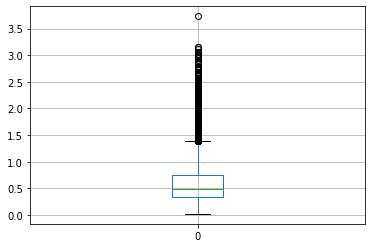

In [14]:
# построим диаграмму размаха
pd.DataFrame(data_arc.loc[:,'Активная мощность':'Реактивная мощность'].stack()).boxplot()

Удалим экстремальные значения мощности. За выбросы будем считать значения, превышающиe Q3 + 3*IQR. Коэффициент при IQR взяли намеренно большой, чтобы не отсечь редкие, но реальные значения мощности.

In [15]:
# запишем все значения мощности в серию power
power = data_arc.loc[:,'Активная мощность':'Реактивная мощность'].stack()
# 25% и 75% квартили
q1 = power.quantile(0.25)
q3 = power.quantile(0.75)
# максимальное значение мощности
max_power = q3+3*(q3-q1)

In [16]:
max_power

2.0198978825499996

In [17]:
# удалим наблюдения со значениями мощности выше, чем max_power
data_arc = data_arc[data_arc['Активная мощность']<=max_power]
data_arc = data_arc[data_arc['Реактивная мощность']<=max_power]

In [18]:
# процент удаленных наблюдений вполне приемлим:
(len_data_arc_0-len(data_arc))/len_data_arc_0*100

1.162947028771175

Создадим новый признак 'energy':   

Энергия равна произведению полной мощности на время.  
Полная мощность равна корню квадратному из суммы квадратов активной мощности и реактивной мощности.  

In [19]:
data_arc['energy'] = ((data_arc['Активная мощность']**2+data_arc['Реактивная мощность']**2)**0.5)*(data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой'])/np.timedelta64(1, 's')

Для каждой партии найдем суммарную энергию, потраченную на нагрев, и сохраним полученный признак в новом датасете arc.

In [20]:
arc = data_arc.pivot_table(index='key', values='energy', aggfunc='sum')

In [21]:
arc.head()

,energy
key,
1,1442.377754
2,881.233565
3,525.066777
4,796.911309
5,1199.137958


**Предобработка данных о подаче сыпучих материалов (объём) - data_bulk.**

In [22]:
# общий вид
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [23]:
# будем использовать номер партии в качестве индекса, назовем датасет bulk
bulk=data_bulk.set_index('key')

In [24]:
# проверим разброс значений данных
bulk.stack().describe()

count    11159.000000
mean       166.980016
std         98.023336
min          1.000000
25%        103.000000
50%        152.000000
75%        206.000000
max       1849.000000
dtype: float64

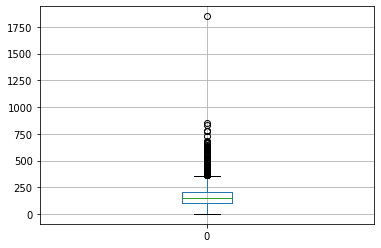

In [25]:
# построим диаграмму размаха
pd.DataFrame(bulk.stack()).boxplot()

Удалим экстремальные значения. За выбросы будем считать значения, превышающиe Q3 + 3*IQR. Коэффициент при IQR взяли намеренно большой, чтобы не отсечь редкие, но реальные значения.

In [26]:
# количество наблюдений в датасете до удаления выбросов
len_bulk_0=len(bulk)
len_bulk_0

3129

In [27]:
# запишем все значения в серию bulk_qty
bulk_qty = bulk.stack()
# 25% и 75% квантили
q1 = bulk_qty.quantile(0.25)
q3 = bulk_qty.quantile(0.75)
# максимальное значение мощности
max_bulk_qty = q3+3*(q3-q1)

In [28]:
max_bulk_qty

515.0

In [29]:
# заменим пропуски на 0
bulk = bulk.fillna(0)

In [30]:
# удалим выбросы
for column in bulk.columns:
    bulk = bulk[bulk[column]<=max_bulk_qty]

In [31]:
# процент удаленных наблюдений вполне приемлим:
(len_bulk_0-len(bulk))/len_bulk_0*100

1.9175455417066156

**Предобработка данных о подаче проволочных материалов (объём) - data_wire.**

In [32]:
# общий вид
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# будем использовать номер партии в качестве индекса, назовем датасет wire
wire=data_wire.set_index('key')

In [34]:
# проверим разброс значений данных
wire.stack().describe()

count    4344.000000
mean       87.751281
std        49.770199
min         0.030160
25%        50.075218
50%        88.441081
75%       118.198082
max       385.008668
dtype: float64

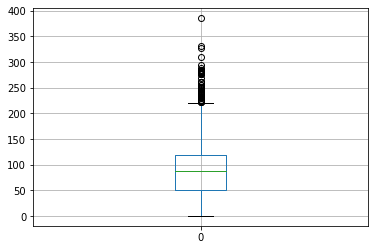

In [35]:
# построим диаграмму размаха
pd.DataFrame(wire.stack()).boxplot()

Здесь удалять выбросы не будем: разница между максимальным значением и медианным представляется лежащей в разумных пределах (они отличаются всего в 4.5 раза, тогда как для насыпных материалов эта разница составляла 12 раз).

In [36]:
# заменим пропуски на 0
wire = wire.fillna(0)

**Предобработка данных о продувке сплава газом - data_gas.**

In [37]:
# общий вид
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [38]:
# будем использовать номер партии в качестве индекса, назовем датасет gas
gas=data_gas.set_index('key')

In [39]:
# переименуем столбец 'Газ 1' в 'gas_1'
gas = gas.rename(columns={'Газ 1':'gas_1'})

In [40]:
# проверим разброс значений данных
gas.describe()

,gas_1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


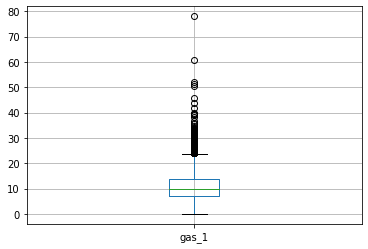

In [41]:
# построим диаграмму размаха
gas.boxplot()

Удалим экстремальные значения. За выбросы будем считать значения, превышающиe Q3 + 3*IQR.
Коэффициент при IQR взяли намеренно большой, чтобы не отсечь редкие, но реальные значения.

In [42]:
# количество наблюдений в датасете до удаления выбросов
len_gas_0=len(gas)
len_gas_0

3239

In [43]:
# 25% и 75% квантили
q1 = gas['gas_1'].quantile(0.25)
q3 = gas['gas_1'].quantile(0.75)
# максимальное значение мощности
max_gas = q3+3*(q3-q1)

In [44]:
max_gas

33.950395734450005

In [45]:
# удалим выбросы
gas = gas[gas['gas_1']<=max_gas]

In [46]:
# процент удаленных наблюдений вполне приемлим:
(len_gas_0-len(gas))/len_gas_0*100

0.5557270762581044

**Предобработка результатов измерения температуры - data_temp.**

In [47]:
# общий вид
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [48]:
# переведем запись данных о времени из формата 'object' в формат 'datetime'
data_temp.loc[:,'Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [49]:
# проверим замеры времени на хронологичность
data_temp['Время замера'].is_monotonic

False

Где-то в записях времени замера нарушена хронологическая последовательность. Для дальнейшей работы нам важно, чтобы хронологический порядок соблюдался в пределах одной партии. Поэтому отсортируем датасет сначала по признаку 'key' (номер партии), затем по 'Время замера'.

In [50]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])

In [51]:
# будем использовать 'key' в качестве индекса, назовем датасет temp
temp = data_temp.set_index('key')

Из полного датасета результатов измерения температуры выделим первые и последние замеры каждой партии - создадим два новых датасета start_temp и end_temp. Start_temp будет одним из признаков, а end_temp - целевым признаком будущей модели.

In [52]:
# заготовка новых датасетов
columns_start=['key', 'start_temp']
data_start = []
columns_end = ['key', 'end_temp']
data_end = []

In [53]:
# выделение первых и последних замеров каждой партии
for k in data_temp['key'].unique():
    # применяем конструкцию try/except, т.к. возможно есть партии с единственным замером,
    # такие наблюдения использовать для решения задачи не можем, поэтому пока оставим пропуск (np.nan)
    try:
        t1 = temp.loc[k,'Температура'].iloc[0] # первый замер температуры в партии
        t2 = temp.loc[k,'Температура'].iloc[-1] # последний замер температуры в партии
    except:
        t1 = np.nan
        t2 = np.nan
    data_start.append([k, t1])
    data_end.append([k, t2])

In [54]:
# создание датасетов первых и последних замеров каждой партии
start_temp = pd.DataFrame(data=data_start, columns = columns_start).set_index('key') # первый замер температуры в партии
end_temp = pd.DataFrame(data=data_end, columns = columns_end).set_index('key') # последний замер температуры в партии

In [55]:
# первые замеры температуры каждой партии
start_temp.head()

,start_temp
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0


In [56]:
start_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 1 columns):
start_temp    3214 non-null float64
dtypes: float64(1)
memory usage: 50.2 KB


In [57]:
# последние замеры температуры каждой партии
end_temp.head()

,end_temp
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


In [58]:
end_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 1 columns):
end_temp    2475 non-null float64
dtypes: float64(1)
memory usage: 50.2 KB


Ожидаемо присутствует большая доля пропущенных данных. Позже такие наблюдения удалим.

**Предобработка данных о времени добавления примесей - data_bulk_time и data_wire_time.**

Т.к. мы не используем промежуточные замеры температуры, то данные о времени добавления примесей тоже использовать не будем.

**Создание сборного датасета всех необходимых признаков.**

Объединим датасеты arc, bulk, wire, gas, start_temp, end_temp в один датасет data. Номер партии 'key' будет индексом.

In [59]:
data = end_temp.join([start_temp, arc, bulk, wire, gas])

In [60]:
pd.set_option('display.max_columns', None)

In [61]:
data.head()

,end_temp,start_temp,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1442.377754,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1602.0,1581.0,881.233565,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1599.0,1596.0,525.066777,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1625.0,1601.0,796.911309,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1602.0,1576.0,1199.137958,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 28 columns):
end_temp      2475 non-null float64
start_temp    3214 non-null float64
energy        3214 non-null float64
Bulk 1        3069 non-null float64
Bulk 2        3069 non-null float64
Bulk 3        3069 non-null float64
Bulk 4        3069 non-null float64
Bulk 5        3069 non-null float64
Bulk 6        3069 non-null float64
Bulk 7        3069 non-null float64
Bulk 8        3069 non-null float64
Bulk 9        3069 non-null float64
Bulk 10       3069 non-null float64
Bulk 11       3069 non-null float64
Bulk 12       3069 non-null float64
Bulk 13       3069 non-null float64
Bulk 14       3069 non-null float64
Bulk 15       3069 non-null float64
Wire 1        3081 non-null float64
Wire 2        3081 non-null float64
Wire 3        3081 non-null float64
Wire 4        3081 non-null float64
Wire 5        3081 non-null float64
Wire 6        3081 non-null float64
Wire 7        3081 non-null f

Т.к. 'end_temp' является целевым признаком, то строки с пропущенными значениями 'end_temp' надо удалить. Также удалим строки с пропусками значений 'start_temp', 'energy', 'Газ 1'.  
Как было замечено при исследовательском анализе, для ряда партий нет информации о добавлении примесей. Возможно два варианта - либо примеси не добавлялись, либо информация утеряна. Будем считать, что примеси не добавлялись, и заменим пропуски на ноль.

In [63]:
# количество наблюдений в оригинальном датасете data
len_data_0=len(data)
len_data_0

3216

In [64]:
data = data.dropna(subset=['end_temp', 'start_temp', 'energy', 'gas_1'])

In [65]:
# процент удаленных наблюдений:
(len_data_0-len(data))/len_data_0*100

23.600746268656717

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 1 to 2499
Data columns (total 28 columns):
end_temp      2457 non-null float64
start_temp    2457 non-null float64
energy        2457 non-null float64
Bulk 1        2341 non-null float64
Bulk 2        2341 non-null float64
Bulk 3        2341 non-null float64
Bulk 4        2341 non-null float64
Bulk 5        2341 non-null float64
Bulk 6        2341 non-null float64
Bulk 7        2341 non-null float64
Bulk 8        2341 non-null float64
Bulk 9        2341 non-null float64
Bulk 10       2341 non-null float64
Bulk 11       2341 non-null float64
Bulk 12       2341 non-null float64
Bulk 13       2341 non-null float64
Bulk 14       2341 non-null float64
Bulk 15       2341 non-null float64
Wire 1        2354 non-null float64
Wire 2        2354 non-null float64
Wire 3        2354 non-null float64
Wire 4        2354 non-null float64
Wire 5        2354 non-null float64
Wire 6        2354 non-null float64
Wire 7        2354 non-null f

In [67]:
# процент наблюдений, когда примеси не добавлялись
(len(data)-2341)/len(data)*100

4.721204721204721

In [68]:
# заменим такие пропуски на ноль
data = data.fillna(0)

In [69]:
data.head()

,end_temp,start_temp,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1442.377754,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1602.0,1581.0,881.233565,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1599.0,1596.0,525.066777,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1625.0,1601.0,796.911309,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1602.0,1576.0,1199.137958,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


### Вывод по предобработке данных.

- В результате предобработки получили датасет data, который содержит целевой признак 'end_temp' (температура сплава на выходе) и признаки, необходимые для обучения модели.  
- При создании датасета пришлось отказаться от 24% всех наблюдений. Такое большое значение удаленных данных объясняется отсутствием замеров температуры в начале и конце обработки сплава.   
- Было сделано допущение: отсутствие информации о добавлении примесей в ряде партий мы интерпретировали как факт неиспользования примесей и заменили такие пропуски на 0. Такие партии составляют 5%. 

### 3. Создание и обучение моделей.

Рассмотрим следующие модели: дерево решений, случайный лес, линейная регрессия и градиентный бустинг.  
Как рекомендовано Team Leader, будем использовать только две выборки - обучающую и тестовую. Для этого разобъем датасет в соотношении 3:1. Соответсвенно будем сравнивать модели по МАЕ на тестовой выборке.

In [70]:
# импорт функций и библиотек
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [71]:
# выделение обучающей и тестовой выборок
train, test = train_test_split(data, test_size=0.25, random_state=12345)

In [72]:
print('Длина выборки')
print('- обучающая: ', len(train))
print('- тестовая: ', len(test))

Длина выборки
- обучающая:  1842
- тестовая:  615


In [73]:
# признаки
x_train = train.drop(columns='end_temp')
x_test = test.drop(columns='end_temp')

In [74]:
# целевой признак
y_train = train['end_temp']
y_test = test['end_temp']

In [75]:
# инициализация масштабирования
scaler = StandardScaler()

In [76]:
# настраиваем scaler по обучающей выборке...
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [77]:
# ... и применяем scaler к обеим выборкам
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [78]:
# заготовка параметров таблиц результатов исследования моделей
columns_summary = ['method','mae', 'max_depth', 'n_estimators','learning_rate', 'num_leaves','min_data_in_leaf','max_bin']
data_tree=[] # для дерева решений
data_forest=[] # для случайного леса
data_lr=[] # для линейной регрессии
data_gb=[] # для градиентного бустинга

**Дерево решений**

In [79]:
%%time

# модель "решающее дерево"
# подбор параметра max_depth

for max_depth in range (4,21,2):
    # создание и обучение модели
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
    model.fit(x_train, y_train)
    # предсказания для тестовых данных и расчет значения метрики
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    # добавление строк в таблицу сравнения моделей
    line_tree=['decision_tree', mae, max_depth, np.nan, np.nan, np.nan, np.nan, np.nan]
    data_tree.append(line_tree)

Wall time: 232 ms


In [80]:
# подготовка таблицы результатов дерева
summary_tree = pd.DataFrame(data=data_tree, columns=columns_summary)
top_tree = summary_tree.sort_values(by = 'mae').head().reset_index(drop=True)

In [81]:
# вывод таблицы лучших результатов дерева
top_tree

,method,mae,max_depth,n_estimators,learning_rate,num_leaves,min_data_in_leaf,max_bin
0,decision_tree,7.774375,6,NaN,NaN,NaN,NaN,NaN
1,decision_tree,7.842559,10,NaN,NaN,NaN,NaN,NaN
2,decision_tree,7.987107,8,NaN,NaN,NaN,NaN,NaN
3,decision_tree,8.444047,4,NaN,NaN,NaN,NaN,NaN
4,decision_tree,8.556540,12,NaN,NaN,NaN,NaN,NaN


**Случайный лес**

In [82]:
%%time

# модель "случайный лес"
# Для экономии времени реально рассмотренные варианты значений закомментируем, оставим только вариант с наилучшими результатами.

for max_depth in [16]: #range (10, 31, 2):
    for n_estimators in [120]: #range(80, 161, 20):
        # создание и обучение модели
        model = RandomForestRegressor (n_estimators=n_estimators, max_depth=max_depth, random_state=12345)
        model.fit(x_train, y_train)
        # предсказания для тестовых данных и расчет значения метрики
        y_pred = model.predict(x_test)
        mae = mean_absolute_error(y_test, y_pred)
        # добавление строк в таблицу сравнения моделей
        line_forest = ['random_forest', mae, max_depth, n_estimators, np.nan, np.nan, np.nan, np.nan]
        data_forest.append(line_forest)

Wall time: 2.89 s


In [83]:
# подготовка таблицы результатов случайного леса
summary_forest = pd.DataFrame(data=data_forest, columns=columns_summary)
top_forest = summary_forest.sort_values(by = 'mae').head().reset_index(drop=True)

In [84]:
# вывод таблицы лучших результатов случайного леса
top_forest

,method,mae,max_depth,n_estimators,learning_rate,num_leaves,min_data_in_leaf,max_bin
0,random_forest,6.867779,16,120,NaN,NaN,NaN,NaN


**Линейная регрессия**

In [85]:
# модель "линейная регрессия"

# создание и обучение модели
model = LinearRegression()
model.fit(x_train, y_train)
# предсказания для тестовых данных и расчет значения метрики
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
# добавление строк в таблицу сравнения моделей
line_lr = ['linear_regression', mae, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
data_lr.append(line_lr)

In [86]:
# подготовка таблицы результатов линейной регрессии
summary_lr = pd.DataFrame(data=data_lr, columns=columns_summary)

In [87]:
# вывод таблицы результатов линейной регрессии
summary_lr

,method,mae,max_depth,n_estimators,learning_rate,num_leaves,min_data_in_leaf,max_bin
0,linear_regression,8.24249,NaN,NaN,NaN,NaN,NaN,NaN


**Gradient Boosting Decision Tree**

In [88]:
%%time

# модель Gradient Boosting Decision Tree

# Подбор параметров (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).
# Для экономии времени реально рассмотренные варианты значений закомментируем, оставим только вариант с наилучшими результатами.

for learning_rate in [0.05]: #[0.02,0.05,0.1,0.3]:
    for max_depth in [6]: #[4,6,8,10]:
        for num_leaves in [25]: #[15, 25, 50, 75]:
            for min_data_in_leaf in [10]: #[5,10,15,20]:
                for n_estimators in [200]: #[100,200,400]:
                    for max_bin in [50]: #[25,50,100]:
                        params = {}
                        params['feature_fraction'] = 0.8
                        params['bagging_freq'] = 2
                        params['bagging_fraction'] = 0.5
                        params['learning_rate'] = learning_rate
                        params['boosting_type'] = 'gbdt'
                        params['objective'] = 'regression'
                        params['metric'] = 'mae'
                        params['max_depth'] = max_depth
                        params['num_leaves'] = num_leaves
                        params['min_data_in_leaf'] = min_data_in_leaf
                        params['max_bin'] = max_bin
                        params['n_estimators'] = n_estimators
                        params['random_state'] = 12345
                        model = lgb.LGBMRegressor(**params)
                        model.fit(x_train, y_train)
                        y_pred = model.predict(x_test)
                        mae = mean_absolute_error(y_test, y_pred)
                        line_gbdt = ['gradient_boosting_decision_tree',mae,  max_depth,  n_estimators, learning_rate,num_leaves,min_data_in_leaf,max_bin]
                        data_gb.append(line_gbdt)

Wall time: 278 ms


In [89]:
# подготовка таблицы результатов градиентного бустинга gbdt
summary_gb = pd.DataFrame(data=data_gb, columns=columns_summary)
top_gb = summary_gb.sort_values(by = 'mae').head().reset_index(drop=True)

In [90]:
# вывод таблицы лучших результатов градиентного бустинга gbdt
top_gb

,method,mae,max_depth,n_estimators,learning_rate,num_leaves,min_data_in_leaf,max_bin
0,gradient_boosting_decision_tree,6.520635,6,200,0.05,25,10,50


### 4. Сравнение моделей и построение графика важности факторов.

**Сравнение моделей.**

In [91]:
# подготовка сводной таблицы результатов всех рассмотренных моделей
summary = pd.concat([top_tree.head(1), top_forest.head(1), summary_lr, top_gb.head(1)]).sort_values('mae').reset_index(drop=True)

In [92]:
# вывод сводной таблицы результатов всех рассмотренных моделей
summary

,method,mae,max_depth,n_estimators,learning_rate,num_leaves,min_data_in_leaf,max_bin
0,gradient_boosting_decision_tree,6.520635,6.0,200.0,0.05,25.0,10.0,50.0
1,random_forest,6.867779,16.0,120.0,NaN,NaN,NaN,NaN
2,decision_tree,7.774375,6.0,NaN,NaN,NaN,NaN,NaN
3,linear_regression,8.242490,NaN,NaN,NaN,NaN,NaN,NaN


Лучшая модель - градиентный бустинг.

**Фиксация лучшей (итоговой) модели.**

In [93]:
# зафиксируем значения параметров лучшего результата
learning_rate1 = summary.loc[0,'learning_rate']
max_depth1 = int(summary.loc[0,'max_depth'])
num_leaves1 = int(summary.loc[0,'num_leaves'])
min_data_in_leaf1 = int(summary.loc[0,'min_data_in_leaf'])
max_bin1 = int(summary.loc[0,'max_bin'])
n_estimators1 = int(summary.loc[0,'n_estimators'])

In [94]:
params['learning_rate'] = learning_rate1
params['max_depth'] = max_depth1
params['num_leaves'] = num_leaves1
params['min_data_in_leaf'] = min_data_in_leaf1
params['max_bin'] = max_bin1
params['n_estimators'] = n_estimators1
model = lgb.LGBMRegressor(**params)
model.fit(x_train, y_train)

LGBMRegressor(bagging_fraction=0.5, bagging_freq=2, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.05, max_bin=50,
              max_depth=6, metric='mae', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=25,
              objective='regression', random_state=12345, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [95]:
# убедимся, что лучшая модель зафиксирована корректно (МАЕ не изменилась)
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
mae

6.52063509265788

**График важности факторов.**

In [96]:
features = data.drop(columns=['end_temp']).columns # список названий факторов

In [97]:
importances = model.feature_importances_ # список значений важности
indices = np.argsort(importances) # сортировка значений важности по возрастанию

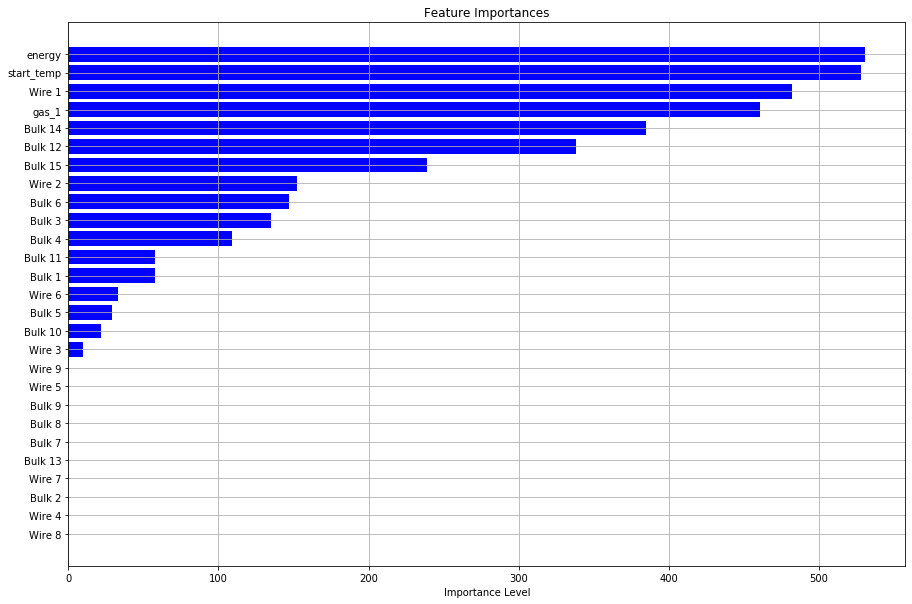

In [98]:
# построение графика

plt.figure(figsize=(15,10))
plt.grid()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance Level')
plt.show()

Анализ важности факторов ожидаемо показал, что наибольший вес имеет значение энергии, затраченной на нагрев, и температура сплава в начале обработки. Неожиданно большой вес оказался у показателя подачи инертного газа.

### 5. Общий вывод.

Была проделана следующая работа:

В ходе предобработки данных получили датасет data, который содержит целевой признак 'end_temp' (температура сплава на выходе) и признаки, необходимые для обучения модели. При создании датасета пришлось отказаться от 24% всех наблюдений. Такое большое значение удаленных данных объясняется отсутствием замеров температуры в начале и конце обработки сплава. Было сделано допущение: отсутствие информации о добавлении примесей в ряде партий мы интерпретировали как факт неиспользования примесей и заменили такие пропуски на 0. Такие партии составляют 5%. 

Были построены и обучены следующие модели: дерево решений, случайный лес, линейная регрессия и градиентный бустинг (LightGBM gradient_boosting_decision_tree). В результате подбора гиперпараметров удалось получить модель с результатом МАЕ = 6.52 (на локальной машине), что удовлетворяет поставленной задаче добиться МАЕ не более 6.8. Наиболее удачной моделью оказалась модель на основе градиентного бустинга.

Анализ важности факторов ожидаемо показал, что наибольший вес имеет значение энергии, затраченной на нагрев, и температура сплава в начале обработки. Неожиданно большой вес оказался у показателя подачи инертного газа.